## Сложные репрезентации

**Примечание в ретроспективе** Здесь я (пока) не загружал веса эмбеддингов в Embedding-слои напрямую, а использовал самый тупой и примитивный метод предобработки с помощью эмбеддингов. Rest assured, на следующих этапах всё используется как положено.

И продолжим мы как водится предобученными эмбеддингами. Сначала используем GoogleNews W2v.

In [6]:
import numpy as np
import gensim

In [11]:
en_w2v = gensim.models.KeyedVectors.load_word2vec_format("embeddings/GoogleNews-vectors-negative300.bin", binary=True)

Сначала представим тексты просто как среднее от векторов их составляющих.

In [15]:
en_w2v['dog'].shape

(300,)

In [23]:
def vectorize(text):
    vectors = []
    for word in text.split():
        try:
            vectors.append(en_w2v[word])
        except KeyError:
            vectors.append(np.zeros((300,)))
    return np.mean(vectors, axis=0)

In [33]:
X_vectors = normalize(np.array([vectorize(text) for text in tqdm(X_text)])).reshape(48000,300,1)

100%|██████████| 48000/48000 [00:04<00:00, 9668.88it/s] 


In [199]:
X_vectors.shape, y.shape

((48000, 300, 1), (48000,))

In [63]:
def train_dev_test(X, y, seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [201]:
X_train, X_val, X_test, y_train, y_val, y_test = train_dev_test(X_vectors, y, 42)

На этом попробуем простую FF-сеть.

In [8]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pythonimous/venv/data-science/lib/pyt

In [9]:
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
seed=42

In [101]:
def build_ff(emb_size, dropout_rate, num_classes):
    word_input = Input(shape=(emb_size,1))
    z = Dense(2048, activation='relu')(word_input)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(1024, activation='relu')(word_input)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(512, activation='relu')(word_input)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(256, activation='relu')(z)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    y = Dense(num_classes, activation='softmax')(z)
    model = Model(inputs=word_input, outputs=y)
    return model

In [140]:
emb_size = 300
dropout_rate = 0.2
batch_size = 512
epochs = 100
num_classes = 3

In [103]:
model = build_ff(emb_size, dropout_rate, num_classes)

In [104]:
mc = ModelCheckpoint('checkpoints/best_ff.h5', monitor='val_loss', mode='auto', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3)

In [105]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               154112    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0   

In [106]:
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [mc, earlystop],
          verbose=1,
          validation_data=(X_val, y_val))

Train on 43200 samples, validate on 2400 samples
Epoch 1/100
43200/43200 [==============================] - 2s 39us/sample - loss: 0.9788 - acc: 0.5928 - val_loss: 1.0463 - val_acc: 0.5050
Epoch 2/100
43200/43200 [==============================] - 1s 18us/sample - loss: 0.7772 - acc: 0.6542 - val_loss: 1.0024 - val_acc: 0.6292
Epoch 3/100
43200/43200 [==============================] - 1s 19us/sample - loss: 0.7276 - acc: 0.6792 - val_loss: 0.9697 - val_acc: 0.5821
Epoch 4/100
43200/43200 [==============================] - 1s 19us/sample - loss: 0.7025 - acc: 0.6943 - val_loss: 0.9050 - val_acc: 0.6363
Epoch 5/100
43200/43200 [==============================] - 1s 19us/sample - loss: 0.6762 - acc: 0.7046 - val_loss: 0.8498 - val_acc: 0.6388
Epoch 6/100
43200/43200 [==============================] - 1s 19us/sample - loss: 0.6583 - acc: 0.7134 - val_loss: 0.8017 - val_acc: 0.6558
Epoch 7/100
43200/43200 [==============================] - 1s 18us/sample - loss: 0.6381 - acc: 0.7243 - val_lo

In [98]:
def plot_train_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plot_epochs = range(1, len(acc) + 1)

    plt.plot(plot_epochs, acc, 'r', label='Training acc')
    plt.plot(plot_epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [103]:
def plot_train_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plot_epochs = range(1, len(loss) + 1)

    plt.plot(plot_epochs, loss, 'r', label='Training loss')
    plt.plot(plot_epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [109]:
model.load_weights('checkpoints/best_ff.h5')
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7156716156005859
Test accuracy: 0.6933333


Обычная feedforward сеть не очень хорошо подходит для решения такой задачи. Попробуем CNN.

In [110]:
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D

In [186]:
def build_cnn(emb_size, dropout_rate, num_classes):
    word_input = Input(shape=(emb_size,1))
    conv1 = Conv1D(26, 2, activation='relu')(word_input)
    conv1 = MaxPooling1D(3)(conv1)
    conv1 = Flatten()(conv1)
    conv1 = BatchNormalization(trainable=True)(conv1)
    z1 = Dense(256, activation='relu')(conv1)
    z1 = BatchNormalization(trainable=True)(z1)
    z1 = Dropout(dropout_rate)(z1)
    z2 = Dense(128, activation='relu')(z1)
    z2 = BatchNormalization(trainable=True)(z2)
    z2 = Dropout(dropout_rate)(z2)
    y = Dense(num_classes, activation='softmax')(z2)
    model = Model(inputs=word_input, outputs=y)
    return model

In [187]:
cnn = build_cnn(emb_size, dropout_rate, num_classes)

In [189]:
mc = ModelCheckpoint('checkpoints/best_cnn.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [190]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['acc'])
print(cnn.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 300, 1)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 299, 26)           78        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 99, 26)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2574)              0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 2574)              10296     
_________________________________________________________________
dense_41 (Dense)             (None, 256)               659200    
_________________________________________________________________
batch_normalization_36 (Batc (None, 256)               102

In [191]:
history=cnn.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks = [mc, earlystop],
        verbose=1,
        validation_data=(X_val, y_val))

Train on 43200 samples, validate on 2400 samples
Epoch 1/100
43200/43200 [==============================] - 6s 147us/sample - loss: 0.9603 - acc: 0.5854 - val_loss: 1.0712 - val_acc: 0.5446
Epoch 2/100
43200/43200 [==============================] - 4s 81us/sample - loss: 0.7706 - acc: 0.6549 - val_loss: 1.0530 - val_acc: 0.4883
Epoch 3/100
43200/43200 [==============================] - 3s 80us/sample - loss: 0.7161 - acc: 0.6840 - val_loss: 1.0391 - val_acc: 0.5183
Epoch 4/100
43200/43200 [==============================] - 4s 82us/sample - loss: 0.6803 - acc: 0.7019 - val_loss: 1.0327 - val_acc: 0.4842
Epoch 5/100
43200/43200 [==============================] - 4s 85us/sample - loss: 0.6466 - acc: 0.7219 - val_loss: 0.9833 - val_acc: 0.5121
Epoch 6/100
43200/43200 [==============================] - 4s 85us/sample - loss: 0.6169 - acc: 0.7362 - val_loss: 0.9168 - val_acc: 0.5683
Epoch 7/100
43200/43200 [==============================] - 4s 88us/sample - loss: 0.5943 - acc: 0.7462 - val_l

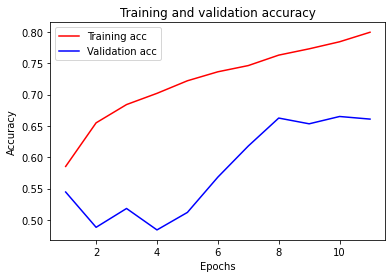

In [192]:
plot_train_acc(history)

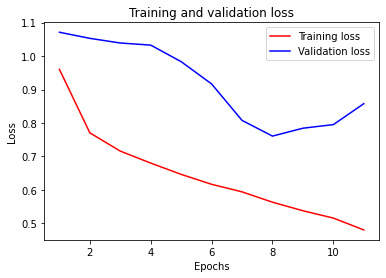

In [193]:
plot_train_loss(history)

In [196]:
cnn.load_weights('checkpoints/best_cnn.h5')
score = cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7434298714001973
Test accuracy: 0.6720833


In [202]:
cnn = build_cnn(emb_size, dropout_rate, num_classes)
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['acc'])
print(cnn.summary())

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 300, 1)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 299, 26)           78        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 99, 26)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2574)              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 2574)              10296     
_________________________________________________________________
dense_44 (Dense)             (None, 256)               659200    
_________________________________________________________________
batch_normalization_39 (Batc (None, 256)               102

In [203]:
cnn.fit(X_vectors, y,
batch_size=batch_size,
epochs=10,
callbacks = [mc],
verbose=1,
validation_data=(X_val, y_val))

Train on 48000 samples, validate on 2400 samples
Epoch 1/10
48000/48000 [==============================] - 5s 101us/sample - loss: 0.9459 - acc: 0.5889 - val_loss: 1.0735 - val_acc: 0.4229
Epoch 2/10
48000/48000 [==============================] - 4s 81us/sample - loss: 0.7639 - acc: 0.6579 - val_loss: 1.0521 - val_acc: 0.6142
Epoch 3/10
48000/48000 [==============================] - 4s 79us/sample - loss: 0.7076 - acc: 0.6901 - val_loss: 1.0285 - val_acc: 0.5471
Epoch 4/10
48000/48000 [==============================] - 4s 79us/sample - loss: 0.6766 - acc: 0.7054 - val_loss: 1.0029 - val_acc: 0.4904
Epoch 5/10
48000/48000 [==============================] - 4s 80us/sample - loss: 0.6461 - acc: 0.7217 - val_loss: 0.8908 - val_acc: 0.6708
Epoch 6/10
48000/48000 [==============================] - 6s 122us/sample - loss: 0.6179 - acc: 0.7362 - val_loss: 0.7492 - val_acc: 0.7233
Epoch 7/10
48000/48000 [==============================] - 4s 82us/sample - loss: 0.5885 - acc: 0.7497 - val_loss: 0

**Примечание в ретроспективе**: не обращай внимание на валидационные цифры, я хз, зачем я валидацию тут оставлял. В общем это просто обучение на всех данных для предсказания результатов на тестовой выборке, не более.

In [205]:
X_test_vectors = normalize(np.array([vectorize(text) for text in tqdm(test['text'])])).reshape(12000,300,1)

100%|██████████| 12000/12000 [00:01<00:00, 8619.64it/s]


In [213]:
outs = [np.argmax(j) for j in cnn.predict(X_test_vectors)]

In [215]:
X_id = test['id']

In [216]:
out_rows=list(zip(X_id, outs))
out_rows = [('Id','Predicted')] + out_rows
out_rows = [f'{t[0]},{t[1]}' for t in out_rows]
with open(f'submissions/4.w2v+cnn.csv', 'w') as a:
    a.write('\n'.join(out_rows))
a.close()

Сабмишн всего 66%: не лучший вариант, даже хуже примитивного бейслайна. Это объяснимо, потому что применять CNN к эмбеддингам подобным образом не имеет особого смысла: между элементами внутри эмбеддинга связи нет. Что имеет смысл, это привести тексты к какой-то длине, представить их как вектора эмбеддингов и брать окна размером e.g. (5,300), чтобы захватить отношения между словами. Так и поступим, и возьмём GloVe 840B GeneralCrawl модель.

In [182]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove2word2vec(glove_input_file="embeddings/glove.840B.300d.txt", word2vec_output_file="embeddings/w2v.840B.300d.txt")

In [183]:
en_w2v = KeyedVectors.load_word2vec_format("embeddings/w2v.840B.300d.txt", binary=False)

In [18]:
text_lengths = [len(t.split()) for t in X_text]

In [23]:
min(text_lengths), max(text_lengths)  # минимальная и максимальная длины текстов

(3, 2163)

In [25]:
sum(l < 10 for l in text_lengths)

388

In [24]:
sorted(text_lengths)[24000], sum(text_lengths) / 48000  # медиана и среднее 

(35, 46.986041666666665)

Выбросы не так сильно воздействуют на среднее, как могло бы оказаться. Возьмём порог в 50 слов! Всё, что больше, будем обрезать, всё, что меньше - дополнять до 50 нулями.

In [184]:
def text_to_matrix(text, size=50):
    text = text.split()
    l = len(text)
    if len(text) < size:
        text = text + ['aAaA']*(size-len(text))  # aAaA is not in vocab and will thus throw KeyError
    else:
        text = text[:size]
    matrix = []
    for word in text:
        try:
            matrix.append(en_w2v[word])
        except KeyError:
            matrix.append(np.zeros(300,))
    return np.array(matrix)

In [185]:
X_text[510]

'many formatting falvours python disclaimer find question offtopic opinionbased toobroad fine gathering drop line comment ill take meanwhile bear second ive recently watched python tutorial author kept juggling various python string formatting expression wa struck thought many string formatting flavour python c language prinf based approach way various source cited deprecated scheduled removal abundance example standard python documentation hand c derived format way handling string finally advent ptyhon weve given formatted fstring literal known fstring also include string module seems overkill found first two aforementioned technique differ overlap depending use last least isnt opulence method contradictory one python declaration import one preferably one obvious way correct im wrong inherently unpythonic way would highly appreciate constructive thought preferably backed relevant example thanks time effort httpsstackoverflowcomquestionspythonstringformattingvsformat'

In [186]:
len(X_text[510].split()), len(X_text[511].split())

(124, 22)

In [187]:
text_to_matrix(X_text[510]).shape, text_to_matrix(X_text[511]).shape

((50, 300), (50, 300))

In [188]:
X = np.array([normalize(text_to_matrix(text)) for text in tqdm(X_text)]).reshape(48000, 300, 50, 1)

100%|██████████| 48000/48000 [00:24<00:00, 1936.06it/s]


In [189]:
X.shape

(48000, 300, 50, 1)

In [190]:
np.save('data/X_train_vectors.npy', X)

In [191]:
X_test_vecs = np.array([normalize(text_to_matrix(text)) for text in tqdm(test['text'])]).reshape(12000, 300, 50, 1)

100%|██████████| 12000/12000 [00:02<00:00, 4597.54it/s]


In [192]:
np.save('data/X_test_vectors.npy', X_test_vecs)

In [193]:
X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test(X, y)

Построим 2D сеть.

In [197]:
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

In [198]:
def build_2d_cnn(emb_size=300, text_size=50, dropout_rate=0.2, num_classes=3):
    word_input = Input(shape=(emb_size, text_size, 1))
    conv1 = Conv2D(filters=3, kernel_size=(7, 7), activation='relu')(word_input)
    conv1 = MaxPooling2D(pool_size=(1,3), strides=None, padding='same')(conv1)
    conv1 = BatchNormalization(trainable=True)(conv1)
    conv2 = Conv2D(filters=5, kernel_size=(3, 3), activation='relu')(conv1)
    conv2 = MaxPooling2D(pool_size=(1,3), strides=None, padding='same')(conv2)
    conv2 = BatchNormalization(trainable=True)(conv2)
    conv3 = Flatten()(conv2)
    z1 = Dense(256, activation='relu')(conv3)
    z1 = BatchNormalization(trainable=True)(z1)
    z1 = Dropout(dropout_rate)(z1)
    z2 = Dense(128, activation='relu')(z1)
    z2 = BatchNormalization(trainable=True)(z2)
    z2 = Dropout(dropout_rate)(z2)
    y = Dense(num_classes, activation='softmax')(z2)
    model = Model(inputs=word_input, outputs=y)
    return model

Я бы рад сделать хорошую сложную архитектуру, но у меня нет в распоряжении офигенного кластера, у ноутбука нет гпу (хотя оперативной памяти выше крыши), а от всего что сложнее колаб отваливается с истерическими воплями, даже если всё предобрабатывать у себя и загружать на диск исключительно npy, так что сорян, и там и здесь работать невозможно

In [199]:
cnn_2d = build_2d_cnn()

In [200]:
mc = ModelCheckpoint('checkpoints/best_2d_cnn.h5', monitor='val_loss', mode='auto', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3)

In [201]:
cnn_2d.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['acc'])
print(cnn_2d.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 300, 50, 1)]      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 294, 44, 3)        150       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 294, 15, 3)        0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 294, 15, 3)        12        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 292, 13, 5)        140       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 292, 5, 5)         0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 292, 5, 5)         20 

In [202]:
batch_size=512
epochs=100

In [203]:
history=cnn_2d.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks = [mc, earlystop],
        verbose=1,
        validation_data=(X_dev, y_dev))

Train on 43200 samples, validate on 2400 samples
Epoch 1/100
43200/43200 [==============================] - 167s 4ms/sample - loss: 0.9868 - acc: 0.5729 - val_loss: 1.8099 - val_acc: 0.3300
Epoch 2/100
43200/43200 [==============================] - 167s 4ms/sample - loss: 0.7373 - acc: 0.6804 - val_loss: 2.2795 - val_acc: 0.3300
Epoch 3/100
43200/43200 [==============================] - 171s 4ms/sample - loss: 0.6264 - acc: 0.7349 - val_loss: 2.8954 - val_acc: 0.3300
Epoch 4/100
43200/43200 [==============================] - 173s 4ms/sample - loss: 0.5167 - acc: 0.7846 - val_loss: 1.7405 - val_acc: 0.3304
Epoch 5/100
43200/43200 [==============================] - 175s 4ms/sample - loss: 0.4095 - acc: 0.8358 - val_loss: 2.1198 - val_acc: 0.3300
Epoch 6/100
43200/43200 [==============================] - 176s 4ms/sample - loss: 0.3163 - acc: 0.8755 - val_loss: 2.0854 - val_acc: 0.3504
Epoch 7/100
43200/43200 [==============================] - 174s 4ms/sample - loss: 0.2456 - acc: 0.9057 -

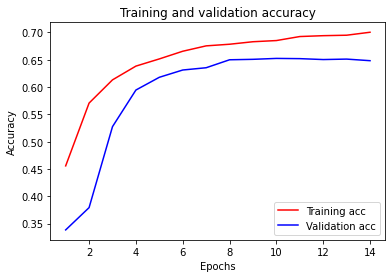

In [119]:
plot_train_acc(history)

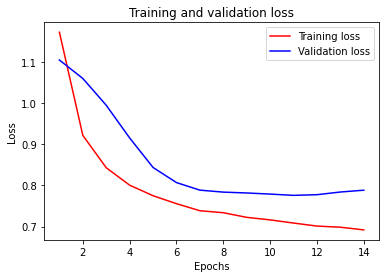

In [120]:
plot_train_loss(history)

### LSTM

В общем, для данной задачи CNN делает мало смысла, жрёт много памяти, вышибает Google Colab и вынуждает рвать волосы на копчике. А что насчёт LSTM, который естественно подходит для задачи обработки текста? Давайте проверим, почему бы и нет!

In [1]:
import tensorflow as tf
import numpy as np

/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pythonimous/venv/data-science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pythonimous/venv/data-science/lib/pyt

In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
from sklearn.preprocessing import normalize
from utils import train_dev_test, plot_train_acc, plot_train_loss, classifier_out

In [4]:
train = pd.read_csv('data/train_texts.csv')
test = pd.read_csv('data/test_texts.csv')

In [5]:
# Сколько максимум слов из словаря нам юзать
MAX_NB_WORDS = 50000
# Ограничимся 250 словами
MAX_SEQUENCE_LENGTH = 250
# Пусть размерность эмбеддинга будет 100
EMBEDDING_DIM = 100

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)

In [8]:
tokenizer.fit_on_texts(train['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 167409 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (48000, 250)


In [10]:
y = train['class']

In [11]:
X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test(X, y)

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.4 , dropout = 0.4)))
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.2 , dropout = 0.2)))
model.add(Dense(3, activation='softmax'))

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 250, 100)          400       
_________________________________________________________________
bidirectional_5 (Bidirection (None, 250, 256)          234496    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 5,629,907
Trainable params: 5,629,707
Non-trainable params: 200
__________________________________________

In [39]:
epochs = 100
#epochs = 3
batch_size = 512

In [40]:
mc = ModelCheckpoint('checkpoints/best_lstm.h5', monitor='val_loss', mode='auto', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [41]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[mc, earlystop],
                    validation_data=(X_dev, y_dev))

Train on 43200 samples, validate on 2400 samples
Epoch 1/100
32256/43200 [=====================>........] - ETA: 2:22 - loss: 0.9011 - acc: 0.5600

KeyboardInterrupt: 

In [26]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2400/2400 [==============================] - 3s 1ms/sample - loss: 0.6578 - acc: 0.7471
Test set
  Loss: 0.658
  Accuracy: 0.747


**Примечание в ретроспективе**: прервал потому что производил обучение (на той же архитектуре) в Google Colab и там в общем-то было быстрее. Резы действительно получились такие, и это первая модель, которая вселила в меня надежду в светлое будущее.

Даже на простейшей LSTMке резы уже лучше, чем они были бы у CNN (у сабмишна 0.742!) Её и будем тюнить, используя при этом дополнительные фичи.

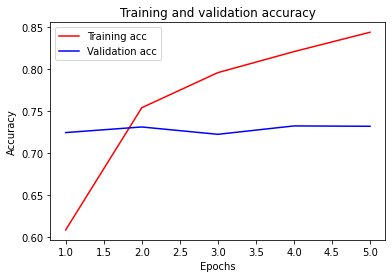

In [27]:
plot_train_acc(history)

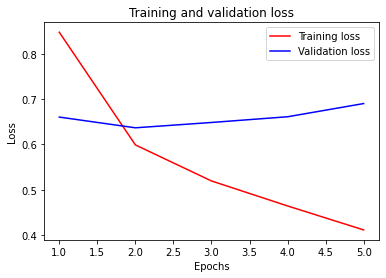

In [28]:
plot_train_loss(history)

**В ретроспективе**: на этом этапе я ещё раз проверил, какие резы на этой задаче (в её нормальной версии) у других людей и как предобрабатывают они. Я решил сказать "а, в задницу всё" и просто тупо, без человеческих способов предобработки типа удаления разметки, попробовать проделать точно так же и посмотреть, что получится.

In [1]:
import os
import random
import re
import time

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 

In [2]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')

In [3]:
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [4]:
train['Body'] = train['Title'] + " " + train['Body']
test['Body'] = test['Title'] + " " + test['Body']

In [5]:
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,I am implementing a Minimum Spanning Forrest a...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"R Studio: Date is getting converted to number,...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,Pandas - dataframe groupby - how to get sum of...,<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,Casting results from Observable.forkJoin to th...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,Environment variable set in batch file cannot ...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [6]:
# Clean the data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

train['Body'] = train['Body'].apply(clean_text)
test['Body'] = test['Body'].apply(clean_text)
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,i am implementing a minimum spanning forrest a...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,r studio date is getting converted to number w...,<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,pandas dataframe groupby how to get sum of m...,<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,casting results from observableforkjoin to the...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,environment variable set in batch file cannot ...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [7]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
example_sent = "This is a sample sentence, showing off the stop words filtration."  
stop_words = set(stopwords.words('english')) 

def remove_stopword(words):
    list_clean = [w for w in words.split(' ') if not w in stop_words]
    return ' '.join(list_clean)

train['Body'] = train['Body'].apply(remove_stopword)
test['Body'] = test['Body'].apply(remove_stopword)
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,implementing minimum spanning forrest algorihm...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,r studio date getting converted number making ...,<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,pandas dataframe groupby get sum multiple co...,<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,casting results observableforkjoin respective ...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,environment variable set batch file cannot acc...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [8]:
X_text = train['Body']
X_test_text = test['Body']
y = train['target']

In [9]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_text)
X_train_counts.shape

(48000, 352497)

In [10]:
X_test_counts = count_vect.transform(X_test_text)
X_test_counts.shape

(12000, 352497)

In [11]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_train_tfidf.shape

(48000, 352497)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.05, random_state=42)

#### LinearSVC

In [15]:
lsvc = LinearSVC().fit(X_train,y_train)

In [16]:
lsvc.score(X_val,y_val)

0.8670833333333333

Получилось, мягко скажем, интересно. С максимально примитивной обработкой и простым классификатором результаты получились лучше всего, что я сделал до того момента, что меня, мягко скажем, расстроило. Я решил проверить, какой именно шаг предобработки всё рушит.

Дополнительных относительно такой простой предобработки шагов было несколько: удаление кода, удаление разметки и лемматизация. Я последовательно с одним и тем же разбиением добавлял шаг предобработки и проверял SVC, чтобы посмотреть, на каком шаге рушится точность.

От лемматизации точность падает. От удаления кода точность падает ОЧЕНЬ сильно.

От удаления разметки точность падает ОЧЕНЬ-ОЧЕНЬ сильно. Не важно даже, убираешь ли ты < > </ > блоки вообще или просто заменяешь угловые скобки пробелами, чтобы тэги с нормальными словами не сливались и не получалось чего-то out-of-dictionary для эмбеддингов - всё едино, один хер, обвал точности просто из-за тэгов, что для меня всё ещё огромная загадка.

На этом этапе я уже не пробовал вообще всё подряд, но попробовал LSTM (с нормальной загрузкой эмбеддингов, она такая же, как будет ноутбуке с моими лучшими резами), LSTM в сочетании с CNN (приложу), и CNN (уже под конец, но не получилось выбиться за 90% и я уже забил, когда увидел, какие результаты у остальных)

В общем архитектура общая - два отдельных входа, языковые фичи с обработкой LSTM / CNN / LSTM-RNN-maxpool / LSTM-CNN / ... на один вход, не-языковые (или относительно языковые) на другой (с последующей конкатенацией), и далее либо полносвязный 512 или 256 слои, либо, пропуская этот этап, сразу на выход.

Для фич прошу обратиться к 4. Feature Engineering.ipynb. Три достойные внимания модели и принёсшую лучший результат я вынес в 5.

Несмотря на то, что я в лабу всадил слишком много времени, я все равно узнал несколько полезных вещей, так что оно в конечном счёте стоило того. Спасибо!